In [9]:
import gym
from gym import spaces
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [121]:
# Defining the Stock Trading Environment.
"""DON'T MAKE ANY CHANGES TO THE ENVIRONMENT."""


class StockTradingEnvironment(gym.Env):
    """This class implements the Stock Trading environment."""

    def __init__(self, file_path, train=True, number_of_days_to_consider=10):
        """This method initializes the environment.

        :param file_path: - Path of the CSV file containing the historical stock data.
        :param train: - Boolean indicating whether the goal is to train or test the performance of the agent.
        :param number_of_days_to_consider = Integer representing the number of days the for which the agent
                considers the trend in stock price to make a decision."""

        self.file_path = file_path
        self.stock_data = pd.read_csv(self.file_path)
        self.train = train

        # Splitting the data into train and test datasets.
        self.training_stock_data = self.stock_data.iloc[:int(0.8 * len(self.stock_data))]
        self.testing_stock_data = self.stock_data.iloc[int(0.8 * len(self.stock_data)):].reset_index()

        self.observation_space = spaces.Discrete(4)
        self.action_space = spaces.Discrete(3)

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # This defines the number of days for which the agent considers the data before taking an action.
        self.number_of_days_to_consider = number_of_days_to_consider
        # The maximum timesteps the agent will take before the episode ends.
        if self.train:
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider
        else:
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider
        # Initializing the number of steps taken to 0.
        self.timestep = 0
        self.reset()

    def reset(self):
        """This method resets the environment and returns the observation.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.

                 info: - info: - A dictionary that can be used to provide additional implementation information."""

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # Initializing the number of steps taken to 0.
        self.timestep = 0

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector that will be passed to the agent.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector.
            observation = [price_increase, stock_held]

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        info = None

        return observation, info

    def step(self, action):
        """This method implements what happens when the agent takes the action to Buy/Sell/Hold.

        :param action: - Integer in the range 0 to 2 inclusive.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.
                 reward: - Integer/Float value that's used to measure the performance of the agent.
                 terminated: - Boolean describing whether the episode has terminated.
                 truncated: - Boolean describing whether a truncation condition outside the scope of the MDP is satisfied.
                 info: - A dictionary that can be used to provide additional implementation information."""

        # We give the agent a penalty for taking actions such as buying a stock when the agent doesn't have the
        # investment capital and selling a stock when the agent doesn't have any shares.
        penalty = 0

        if self.train:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.training_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value +=\
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider]\
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        else:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.testing_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = self.training_stock_data['Open'][
                                           self.timestep + self.number_of_days_to_consider] * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        # Determining if the agent currently has shares of the stock or not.
        if self.number_of_shares > 0:
            stock_held = True
        else:
            stock_held = False

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        self.timestep += 1  # Increasing the number of steps taken by the agent by 1.

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        # Computing the total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # Appending the total account value of the list to plot the graph.
        self.total_account_value_list.append(self.total_account_value)

        # The episode terminates when the maximum timesteps have been reached.
        terminated = True if (self.timestep >= self.max_timesteps) \
            else False
        truncated = False
        info = {}

        return observation, reward, terminated, truncated, info

    def render(self, mode='human'):
        """This method renders the agent's total account value over time.

        :param mode: 'human' renders to the current display or terminal and returns nothing."""

        plt.figure(figsize=(15, 10))
        plt.plot(self.total_account_value_list, color='lightseagreen', linewidth=7)
        plt.xlabel('Days', fontsize=32)
        plt.ylabel('Total Account Value', fontsize=32)
        plt.title('Total Account Value over Time', fontsize=38)
        plt.grid()
        plt.show()

In [105]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt

class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        output = F.softmax(x, dim=-1)
        return output

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [106]:
def one_hot_encode(state, state_dimension):
    one_hot_state = torch.zeros(state_dimension)
    one_hot_state[state] = 1
    return one_hot_state

def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return torch.stack(returns)

In [107]:
def a2c_step(actor, critic, actor_optimizer, critic_optimizer, states, actions, rewards, next_state, dones, gamma=0.99):
    states = torch.stack(states).squeeze()
    actions = torch.stack(actions).squeeze()
    rewards = torch.tensor(rewards, dtype=torch.float32)
    next_state = next_state.squeeze() if next_state.dim() > 1 else next_state
    dones = torch.tensor(dones, dtype=torch.bool)


    current_values = critic(states)
    next_values = critic(next_state)


    masks = ~dones
    returns = compute_returns(next_values, rewards, masks, gamma)


    action_probs = actor(states)
    log_probs = torch.log(action_probs)
    print("Action probabilities shape:", action_probs.shape)
    print("Actions shape:", actions.shape)
    action_log_probs = log_probs.gather(1, actions.unsqueeze(1))

    advantages = returns.squeeze() - current_values.detach().squeeze()
    actor_loss = -(advantages * action_log_probs).mean()


    critic_loss = F.mse_loss(current_values.squeeze(), returns.squeeze())


    actor_optimizer.zero_grad()
    critic_optimizer.zero_grad()
    total_loss = actor_loss + critic_loss
    total_loss.backward()
    actor_optimizer.step()
    critic_optimizer.step()

    return actor_loss.item(), critic_loss.item()


In [108]:
def train(env, actor, critic, actor_optimizer, critic_optimizer, num_episodes=1000):
    for episode in range(num_episodes):
        state = env.reset()
        state = one_hot_encode(state, env.observation_space.n)
        done = False
        total_reward = 0
        states, actions, rewards, dones = [], [], [], []

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs = actor(state_tensor)
            dist = Categorical(action_probs)
            action = dist.sample()

            next_state, reward, terminated, truncated, _ = env.step(action.item())
            next_state = one_hot_encode(next_state, env.observation_space.n)

            states.append(state_tensor)
            actions.append(action)
            rewards.append(reward)
            dones.append(terminated or truncated)

            state = next_state
            total_reward += reward
            done = terminated or truncated

            if done:
                a2c_step(actor, critic, actor_optimizer, critic_optimizer, states, actions, rewards, next_state, dones)
                print(f'Episode: {episode}, Total Reward: {total_reward}')

if __name__ == '__main__':
    env = StockTradingEnvironment(file_path='./NVDA.csv', number_of_days_to_consider=10)
    actor = Actor(env.observation_space.n, env.action_space.n)
    critic = Critic(env.observation_space.n)
    actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)
    critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)
    train(env, actor, critic, actor_optimizer, critic_optimizer)

Action probabilities shape: torch.Size([393, 3])
Actions shape: torch.Size([393])
Episode: 0, Total Reward: -1516.1487825512327
Action probabilities shape: torch.Size([393, 3])
Actions shape: torch.Size([393])
Episode: 1, Total Reward: -1614.425407621247
Action probabilities shape: torch.Size([393, 3])
Actions shape: torch.Size([393])
Episode: 2, Total Reward: -1208.0141879582386
Action probabilities shape: torch.Size([393, 3])
Actions shape: torch.Size([393])
Episode: 3, Total Reward: -1496.4420403059107
Action probabilities shape: torch.Size([393, 3])
Actions shape: torch.Size([393])
Episode: 4, Total Reward: -1350.570263427327
Action probabilities shape: torch.Size([393, 3])
Actions shape: torch.Size([393])
Episode: 5, Total Reward: -1407.2825402940512
Action probabilities shape: torch.Size([393, 3])
Actions shape: torch.Size([393])
Episode: 6, Total Reward: -1255.5332610731339
Action probabilities shape: torch.Size([393, 3])
Actions shape: torch.Size([393])
Episode: 7, Total Reward

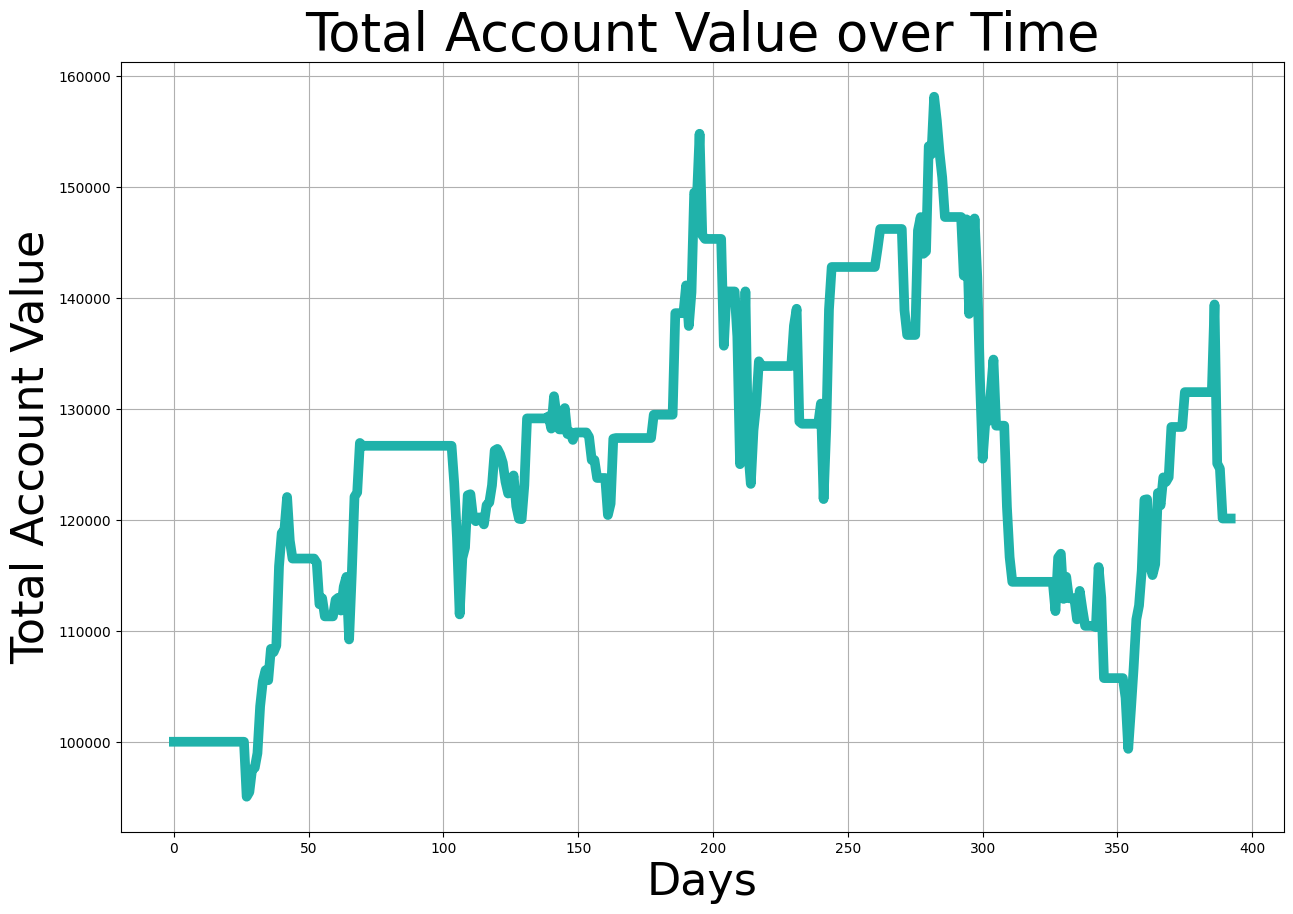

In [109]:
env.render()

Test Episode: 1, Total Reward: 383.5071351958491, Account Value: 145113.12652
Test Episode: 2, Total Reward: 383.5071351958491, Account Value: 145113.12652
Test Episode: 3, Total Reward: 383.5071351958491, Account Value: 145113.12652
Test Episode: 4, Total Reward: 383.5071351958491, Account Value: 145113.12652
Test Episode: 5, Total Reward: 383.5071351958491, Account Value: 145113.12652
Test Episode: 6, Total Reward: 383.5071351958491, Account Value: 145113.12652
Test Episode: 7, Total Reward: 383.5071351958491, Account Value: 145113.12652
Test Episode: 8, Total Reward: 383.5071351958491, Account Value: 145113.12652
Test Episode: 9, Total Reward: 383.5071351958491, Account Value: 145113.12652
Test Episode: 10, Total Reward: 383.5071351958491, Account Value: 145113.12652
Test Episode: 11, Total Reward: 383.5071351958491, Account Value: 145113.12652
Test Episode: 12, Total Reward: 383.5071351958491, Account Value: 145113.12652
Test Episode: 13, Total Reward: 383.5071351958491, Account Va

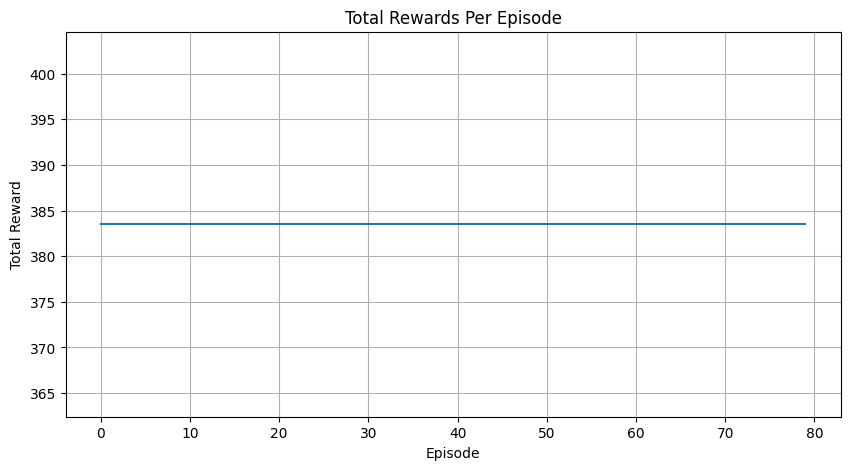

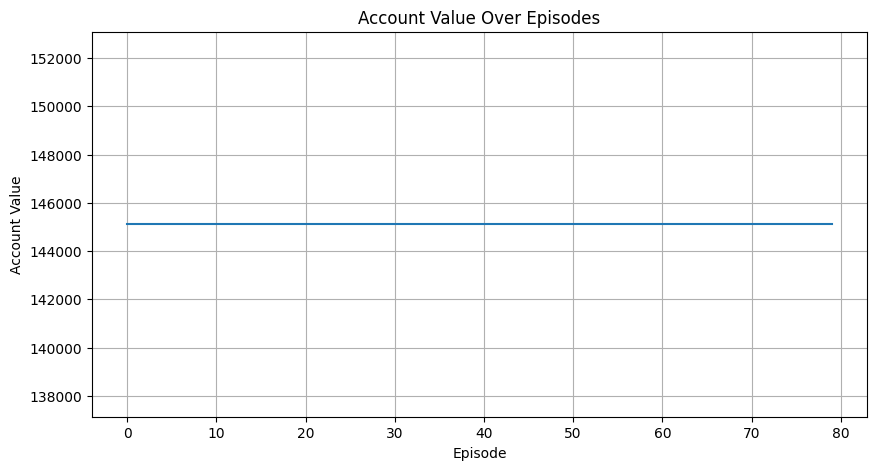

In [110]:
def test_actor_critic_agent(env, actor, num_episodes=10):
    """Test the trained actor for a given number of episodes and visualize the results."""
    total_rewards = []
    account_values = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        state = one_hot_encode(state, env.observation_space.n)
        done = False
        total_reward = 0

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_probs = actor(state_tensor)
                action = torch.argmax(action_probs).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = one_hot_encode(next_state, env.observation_space.n)

            state = next_state
            total_reward += reward
            done = terminated or truncated

        total_rewards.append(total_reward)
        account_values.append(env.total_account_value)
        print(f"Test Episode: {episode + 1}, Total Reward: {total_reward}, Account Value: {env.total_account_value}")


    plt.figure(figsize=(10, 5))
    plt.plot(total_rewards)
    plt.title('Total Rewards Per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(10, 5))
    plt.plot(account_values)
    plt.title('Account Value Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Account Value')
    plt.grid(True)
    plt.show()

    return total_rewards, account_values


if __name__ == '__main__':
    file_path = './NVDA.csv'
    env = StockTradingEnvironment(file_path=file_path, number_of_days_to_consider=10, train=False)
    input_dim = env.observation_space.n
    output_dim = env.action_space.n
    actor = Actor(input_dim, output_dim)



    test_actor_critic_agent(env, actor, num_episodes=80)


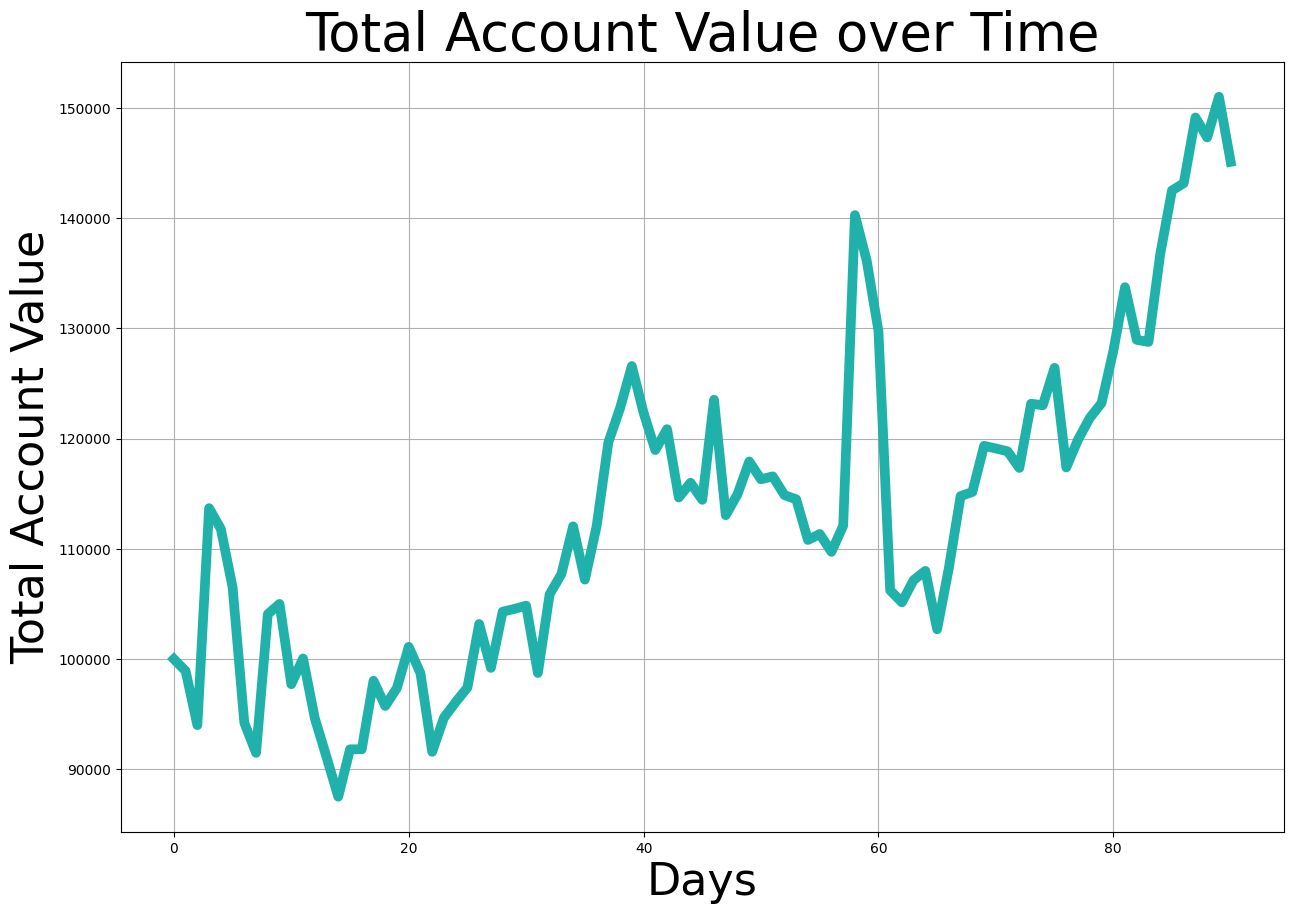

In [111]:
env.render()

In [142]:
class AWRNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AWRNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.actor = nn.Linear(128, output_dim)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        action_probs = F.softmax(self.actor(x), dim=-1)
        value = self.critic(x)
        return action_probs, value

def compute_advantages(returns, values, beta=1.0):
    advantages = returns - values
    weighted_advantages = torch.exp(beta * (advantages - advantages.max()))
    return weighted_advantages

In [143]:
def awr_update(network, optimizer, states, actions, returns, beta=1.0):
    action_probs, values = network(states)
    log_probs = torch.log(action_probs + 1e-8)


    log_probs_action = log_probs.gather(1, actions)


    weighted_advantages = compute_advantages(returns, values.detach(), beta)


    policy_loss = -(log_probs_action * weighted_advantages).mean()


    critic_loss = F.mse_loss(values.squeeze(), returns)


    total_loss = policy_loss + critic_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    return policy_loss.item(), critic_loss.item()

def compute_advantages(returns, values, beta=1.0):
    advantages = returns - values
    weighted_advantages = torch.exp(beta * (advantages - advantages.max()))
    return weighted_advantages


In [144]:
def preprocess_state(state):

    state_tensor = torch.zeros(env.observation_space.n)
    state_tensor[state] = 1
    return state_tensor

def train_awr(env, network, optimizer, num_episodes=1000, beta=1.0):
    for episode in range(num_episodes):

        raw_state, _ = env.reset()
        state = preprocess_state(raw_state)

        done = False
        total_reward = 0
        states, actions, rewards = [], [], []

        while not done:
            state_tensor = state.unsqueeze(0)
            action_probs, _ = network(state_tensor)
            dist = Categorical(action_probs)
            action = dist.sample()

            raw_next_state, reward, terminated, truncated, _ = env.step(action.item())
            next_state = preprocess_state(raw_next_state)

            states.append(state_tensor)
            actions.append(action)
            rewards.append(reward)

            state = next_state
            total_reward += reward
            done = terminated or truncated


        states = torch.cat(states)
        actions = torch.stack(actions).long().view(-1, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32)


        returns = compute_returns(rewards, gamma=0.99)


        policy_loss, critic_loss = awr_update(network, optimizer, states, actions, returns, beta)

        print(f'Episode: {episode}, Total Reward: {total_reward}, Policy Loss: {policy_loss}, Critic Loss: {critic_loss}')

def compute_returns(rewards, gamma=0.99):

    R = 0
    returns = []
    for reward in reversed(rewards):
        R = reward + gamma * R
        returns.insert(0, R)
    return torch.tensor(returns, dtype=torch.float32)



if __name__ == '__main__':
    env = StockTradingEnvironment(file_path='./NVDA.csv', number_of_days_to_consider=10)
    network = AWRNetwork(env.observation_space.n, env.action_space.n)
    optimizer = optim.Adam(network.parameters(), lr=1e-3)
    train_awr(env, network, optimizer)


Episode: 0, Total Reward: -1497.4731683469847, Policy Loss: 0.0052116126753389835, Critic Loss: 101919.921875
Episode: 1, Total Reward: -1462.9045296666175, Policy Loss: 0.0024461678694933653, Critic Loss: 86898.0625
Episode: 2, Total Reward: -1144.0565549917637, Policy Loss: 0.0024480123538523912, Critic Loss: 47857.94921875
Episode: 3, Total Reward: -1459.6959449382296, Policy Loss: 0.0024799371603876352, Critic Loss: 86348.75
Episode: 4, Total Reward: -1275.6048595096129, Policy Loss: 0.003486749017611146, Critic Loss: 69640.40625
Episode: 5, Total Reward: -1255.4202213965457, Policy Loss: 0.0024767667055130005, Critic Loss: 68189.9765625
Episode: 6, Total Reward: -1114.5736798143782, Policy Loss: 0.00520655931904912, Critic Loss: 46621.140625
Episode: 7, Total Reward: -1303.4125125439684, Policy Loss: 0.002461926080286503, Critic Loss: 72418.4296875
Episode: 8, Total Reward: -1217.5754013072358, Policy Loss: 0.0024823658168315887, Critic Loss: 65939.28125
Episode: 9, Total Reward: 

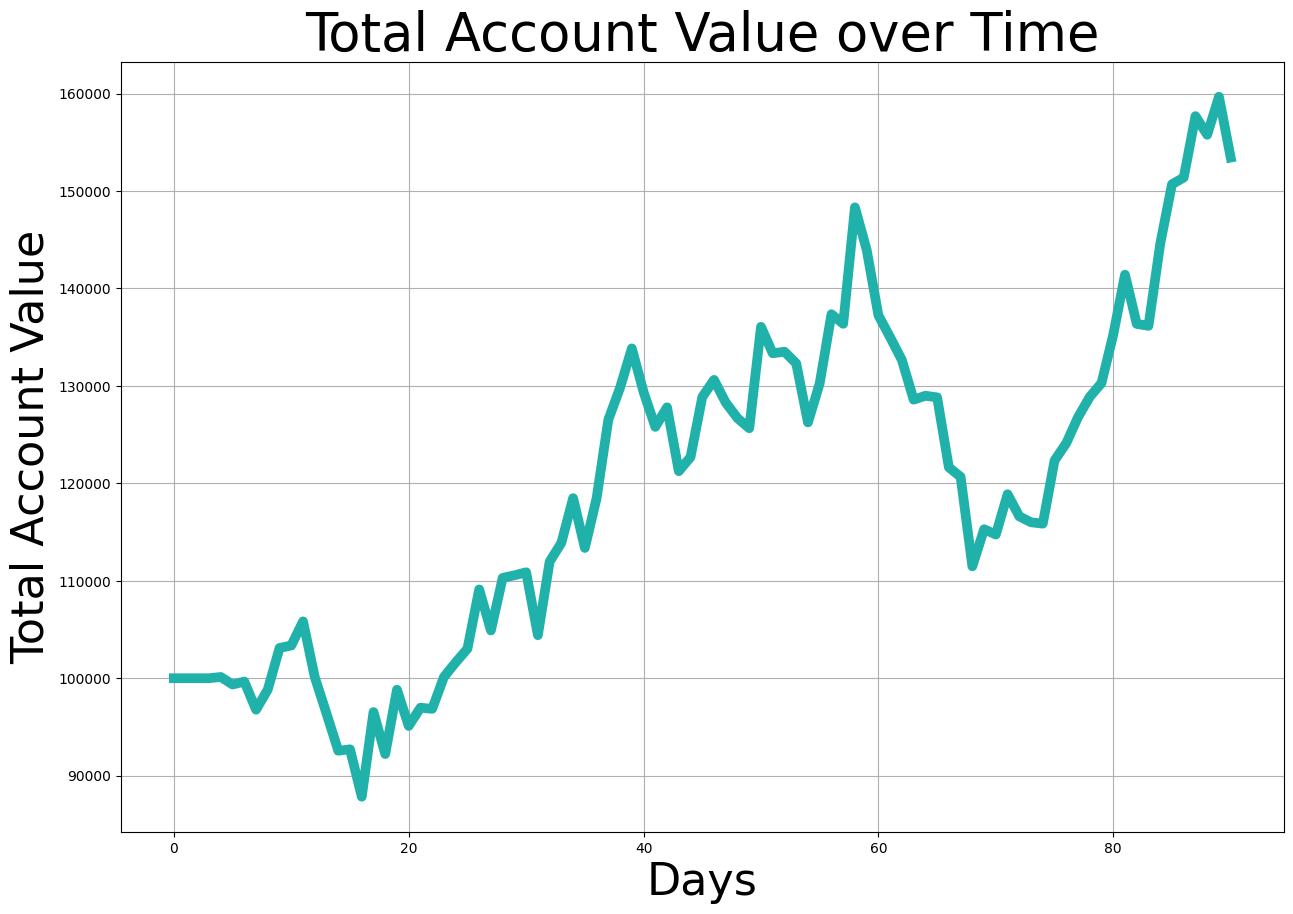

In [163]:
env.render()

Test Episode: 1, Total Reward: 1795.7300240899829, Account Value: 153428.0024
Test Episode: 2, Total Reward: 1795.7300240899829, Account Value: 153428.0024
Test Episode: 3, Total Reward: 1795.7300240899829, Account Value: 153428.0024
Test Episode: 4, Total Reward: 1795.7300240899829, Account Value: 153428.0024
Test Episode: 5, Total Reward: 1795.7300240899829, Account Value: 153428.0024
Test Episode: 6, Total Reward: 1795.7300240899829, Account Value: 153428.0024
Test Episode: 7, Total Reward: 1795.7300240899829, Account Value: 153428.0024
Test Episode: 8, Total Reward: 1795.7300240899829, Account Value: 153428.0024
Test Episode: 9, Total Reward: 1795.7300240899829, Account Value: 153428.0024
Test Episode: 10, Total Reward: 1795.7300240899829, Account Value: 153428.0024


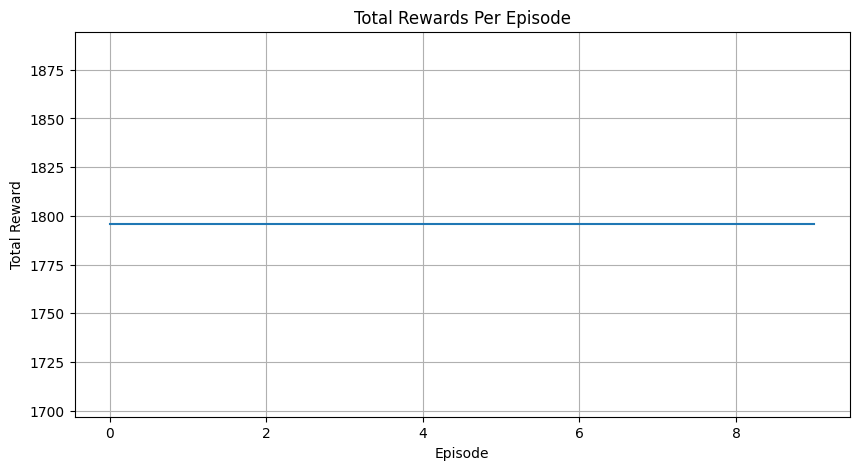

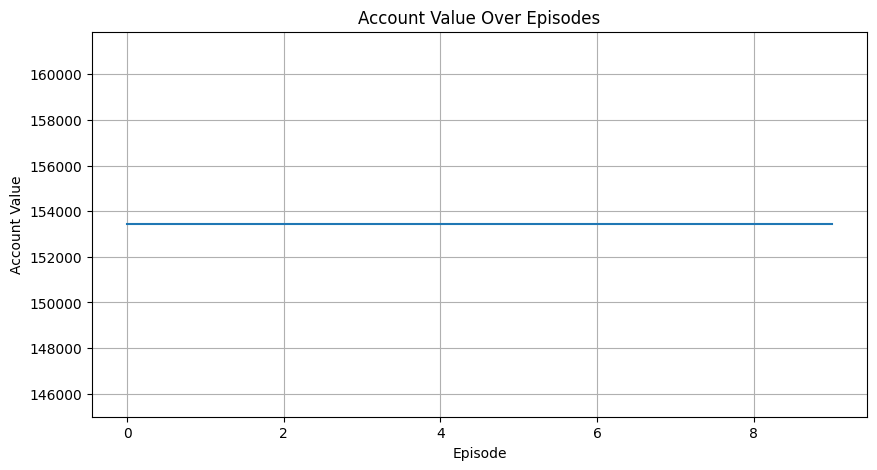

In [161]:
import torch
import matplotlib.pyplot as plt

def test_actor_critic_agent(env, actor_critic, num_episodes=10):
    """Test the trained actor-critic agent for a given number of episodes and visualize the results."""
    total_rewards = []
    account_values = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        state = preprocess_state(state)
        done = False
        total_reward = 0

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_probs, _ = actor_critic(state_tensor)
                action = torch.argmax(action_probs).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = preprocess_state(next_state)

            state = next_state
            total_reward += reward
            done = terminated or truncated

        total_rewards.append(total_reward)
        account_values.append(env.total_account_value)
        print(f"Test Episode: {episode + 1}, Total Reward: {total_reward}, Account Value: {env.total_account_value}")


    plt.figure(figsize=(10, 5))
    plt.plot(total_rewards)
    plt.title('Total Rewards Per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(10, 5))
    plt.plot(account_values)
    plt.title('Account Value Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Account Value')
    plt.grid(True)
    plt.show()

    return total_rewards, account_values


if __name__ == '__main__':
    file_path = './NVDA.csv'
    env = StockTradingEnvironment(file_path=file_path, number_of_days_to_consider=10, train=False)
    input_dim = env.observation_space.n
    output_dim = env.action_space.n
    actor_critic = AWRNetwork(input_dim, output_dim)



    test_actor_critic_agent(env, actor_critic, num_episodes=10)


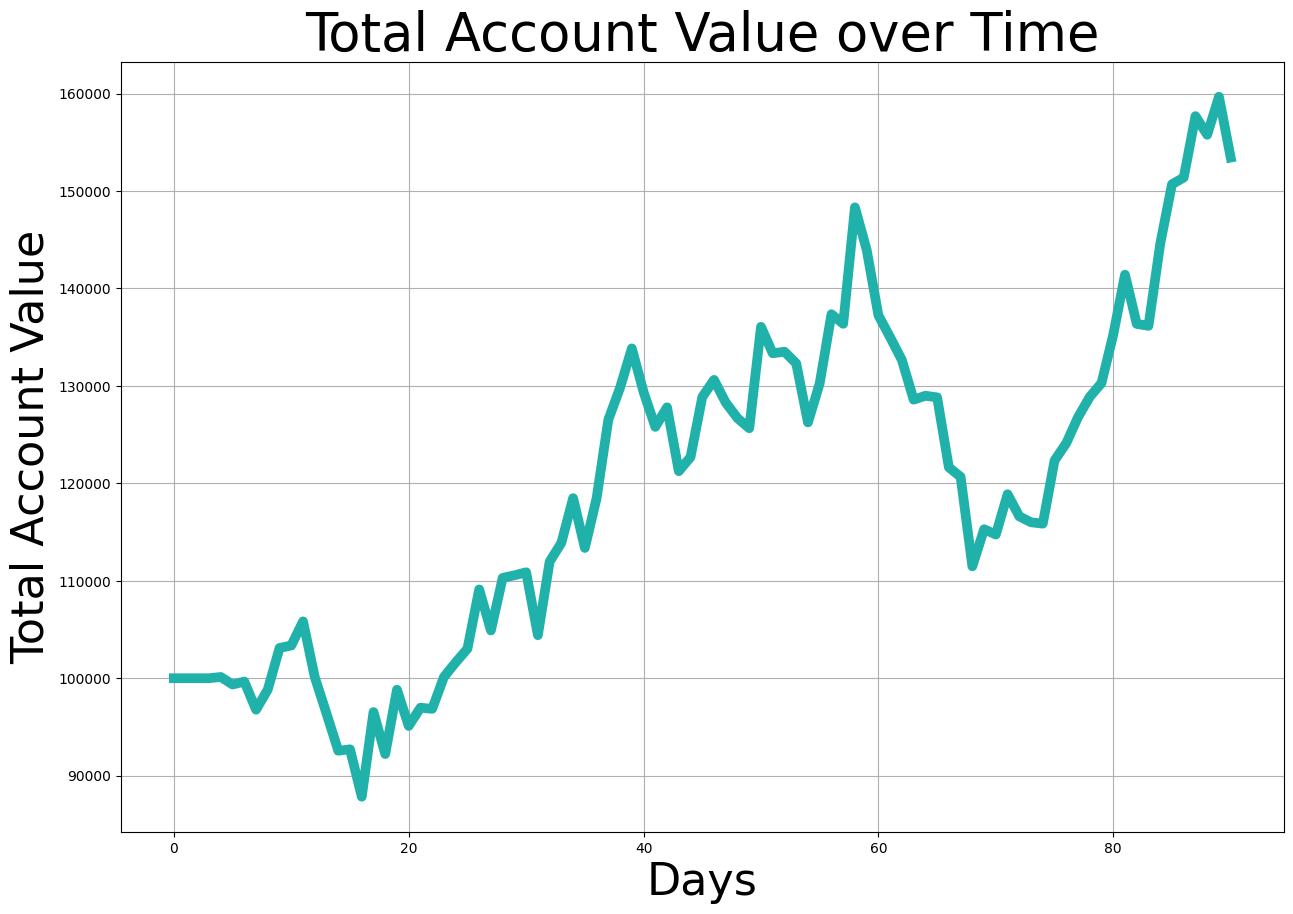

In [162]:
env.render()